# **Diabetes** 

Analisis del Dataset Diabetes 130-US hospitals for years 1999-2008 Data Set. El objetivo es construir un modelo de clasificación que estime si un paciente sera readmitido en menos de 30 dias, con el fin acticiparse a este evento.

Link : https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

# **Imports** 

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Imports-Machine learning 
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import multiprocessing
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# **Exploracion Datasets** 

In [2]:
#Read files
diabetic_df = pd.read_csv("/content/drive/MyDrive/Diabetes/diabetic_data.csv", sep =',')
IDs_mapping_df = pd.read_csv("/content/drive/MyDrive/Diabetes/IDs_mapping.csv", sep =',')

## Estructura datos

In [3]:
print('diabetic_df tiene {} filas y {} columnas'.format(diabetic_df.shape[0],diabetic_df.shape[1]))
diabetic_df.head(10)

diabetic_df tiene 101766 filas y 50 columnas


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
print('IDs_mapping_df tiene {} filas y {} columnas'.format(IDs_mapping_df.shape[0],IDs_mapping_df.shape[1]))
IDs_mapping_df.head(10)

IDs_mapping_df tiene 67 filas y 2 columnas


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


In [5]:
IDs_mapping_df=IDs_mapping_df.iloc[0:8]
IDs_mapping_df['admission_type_id'] = IDs_mapping_df['admission_type_id'].astype(int)

In [6]:
IDs_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   admission_type_id  8 non-null      int64 
 1   description        7 non-null      object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [7]:
diabetic_df=diabetic_df.join(IDs_mapping_df.set_index('admission_type_id'), on='admission_type_id')

In [8]:
diabetic_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency


# **Preparacion de datos**

## Valores Unicos, nulos y tipo de datos, variables enriquecidad


In [9]:
# Se remplaza ? con ningun nan, ya que no se conoce el dato.
diabetic_df.replace('?', np.nan , inplace=True)

In [10]:
def descripcion_base(df):
  columna=[]
  tipo_dato=[]
  total_valores=[]
  total_nulos=[]
  porcentaje_nulos=[]
  cantidad_valores_unicos=[]
  valores_unicos=[]

  for col in df.columns:
    columna.append(col)
    tipo_dato.append(df[col].dtype)
    total_valores.append(df[col].shape[0])
    total_nulos.append(df[col].isnull().sum())
    porcentaje_nulos.append(round(df[col].isnull().sum()/df[col].shape[0],4))
    cantidad_valores_unicos.append(len(df[col].unique()))
    valores_unicos.append(df[col].unique())

  descripcion_base_df = pd.DataFrame({"columna":columna,"tipo_dato":tipo_dato,"total_valores":total_valores,"total_nulos":total_nulos,"porcentaje_nulos":porcentaje_nulos,"cantidad_valores_unicos":cantidad_valores_unicos,"valores_unicos":valores_unicos
                              })
    
  return descripcion_base_df

In [11]:
descripcion_base(diabetic_df)

,columna,tipo_dato,total_valores,total_nulos,porcentaje_nulos,cantidad_valores_unicos,valores_unicos
0,encounter_id,int64,101766,0,0.0000,101766,"[2278392, 149190, 64410, 500364, 16680, 35754,..."
1,patient_nbr,int64,101766,0,0.0000,71518,"[8222157, 55629189, 86047875, 82442376, 425192..."
2,race,object,101766,2273,0.0223,6,"[Caucasian, AfricanAmerican, nan, Other, Asian..."
3,gender,object,101766,0,0.0000,3,"[Female, Male, Unknown/Invalid]"
4,age,object,101766,0,0.0000,10,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
5,weight,object,101766,98569,0.9686,10,"[nan, [75-100), [50-75), [0-25), [100-125), [2..."
6,admission_type_id,int64,101766,0,0.0000,8,"[6, 1, 2, 3, 4, 5, 8, 7]"
7,discharge_disposition_id,int64,101766,0,0.0000,26,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1..."
8,admission_source_id,int64,101766,0,0.0000,17,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22..."
9,time_in_hospital,int64,101766,0,0.0000,14,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]"


In [12]:
# Eliminacion de variables con missing values, valores unicos y sin ningun aporte de informacion.

drop_variables = ['encounter_id','weight','payer_code','medical_specialty','examide','citoglipton','patient_nbr', 'metformin-rosiglitazone','admission_type_id'] 
diabetic_df.drop(drop_variables,axis=1, inplace=True)

In [13]:
# Eliminar los registros vacios de la variable de genero
diabetic_df.gender.replace('Unknown/Invalid', np.nan , inplace=True)
diabetic_df.dropna(subset=['gender'], how='all', inplace = True)

In [14]:
# Eliminar los registros vacios de la variable de raza
diabetic_df.dropna(subset=['race'], how='all', inplace = True)
diabetic_df.dropna(subset=['description'], how='all', inplace = True)

In [15]:
def limpieza_diag(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def categorizacion(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
      category = 'NA'
    else :
        category = 'Other'

    return category

In [16]:
# Se crea la variable de categoria según la documentacion de la base en base de las variables diag_1, diag_2, diag_2 
diag_list=['diag_1', 'diag_2', 'diag_3' ]

for diag in diag_list:
  diabetic_df[diag].fillna('NaN', inplace=True)
  diabetic_df[diag] = diabetic_df[diag].apply(limpieza_diag)
  diabetic_df[diag] = diabetic_df[diag].astype(float)
  diabetic_df[diag] = diabetic_df[diag].apply(categorizacion)

In [17]:
# Se crea una variable final con los distintos diagnosticos
def diagnostico_concatenado(row):
  list_diag_final=[]
  list_diag_final.append(row['diag_1'])
  list_diag_final.append(row['diag_2'])
  list_diag_final.append(row['diag_3'])
  cleanedList = [i for i in list_diag_final if i != 'NA']
  return ' '.join(list(set(cleanedList)))

In [18]:
diabetic_df['dignosticos'] = diabetic_df.apply(diagnostico_concatenado, axis=1)

In [19]:
#Volver binarias las variables change , diabetesMed, readmitted
diabetic_df.change.replace({'No': 0,'Ch': 1}, inplace=True)
diabetic_df.diabetesMed.replace({'No': 0,'Yes': 1}, inplace=True)
diabetic_df.readmitted = [1 if each=='<30' else 0 for each in diabetic_df.readmitted]

In [20]:
descripcion_base(diabetic_df)

,columna,tipo_dato,total_valores,total_nulos,porcentaje_nulos,cantidad_valores_unicos,valores_unicos
0,race,object,94267,0,0.0,5,"[Caucasian, AfricanAmerican, Other, Asian, His..."
1,gender,object,94267,0,0.0,2,"[Female, Male]"
2,age,object,94267,0,0.0,10,"[[10-20), [20-30), [30-40), [40-50), [50-60), ..."
3,discharge_disposition_id,int64,94267,0,0.0,25,"[1, 3, 6, 2, 5, 11, 7, 4, 8, 14, 13, 18, 12, 1..."
4,admission_source_id,int64,94267,0,0.0,17,"[7, 2, 4, 1, 6, 20, 5, 8, 17, 3, 9, 14, 10, 22..."
5,time_in_hospital,int64,94267,0,0.0,14,"[3, 2, 1, 4, 5, 13, 12, 9, 7, 10, 11, 6, 8, 14]"
6,num_lab_procedures,int64,94267,0,0.0,114,"[59, 11, 44, 51, 31, 70, 73, 68, 33, 47, 62, 6..."
7,num_procedures,int64,94267,0,0.0,7,"[0, 5, 1, 6, 2, 3, 4]"
8,num_medications,int64,94267,0,0.0,75,"[18, 13, 16, 8, 21, 12, 28, 17, 11, 15, 31, 2,..."
9,number_outpatient,int64,94267,0,0.0,39,"[0, 2, 1, 5, 7, 9, 3, 8, 4, 12, 11, 6, 20, 15,..."


## **Analisis de datos**

In [21]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper')

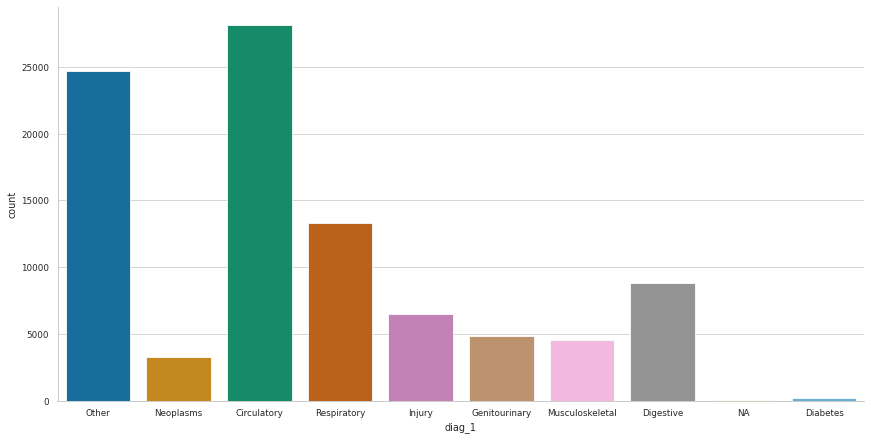

In [22]:
sns.catplot(x = "diag_1", data = diabetic_df, kind = "count", height = 6, aspect = 2);

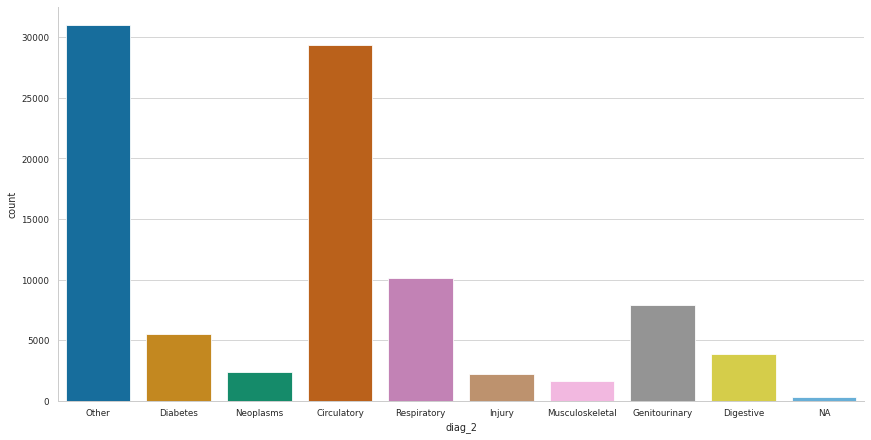

In [23]:
sns.catplot(x = "diag_2", data = diabetic_df, kind = "count", height = 6, aspect = 2);

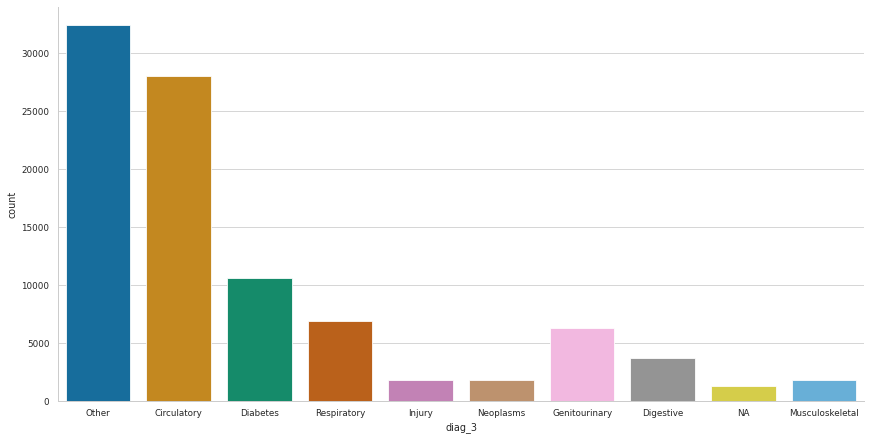

In [24]:
sns.catplot(x = "diag_3", data = diabetic_df, kind = "count", height = 6, aspect = 2);

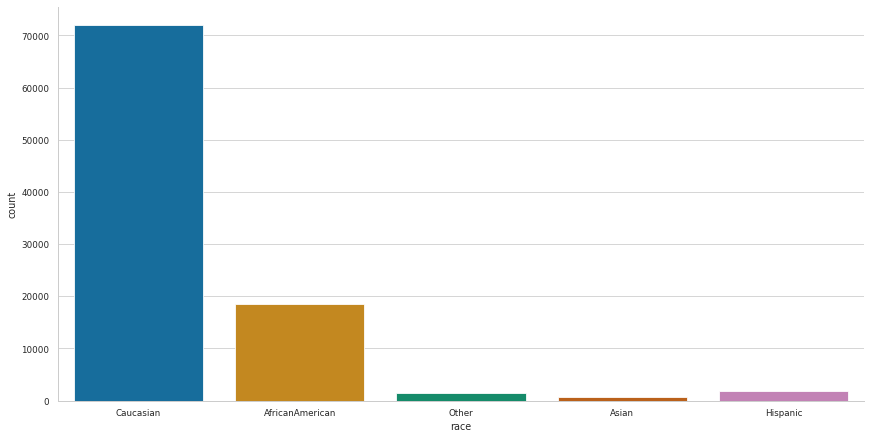

In [25]:
sns.catplot(x = "race", data = diabetic_df, kind = "count", height = 6, aspect = 2);

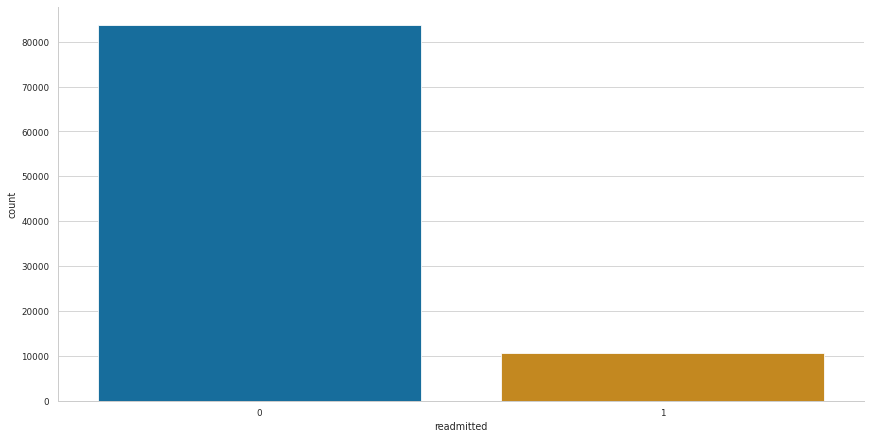

In [26]:
sns.catplot(x = "readmitted", data = diabetic_df, kind = "count", height = 6, aspect = 2);

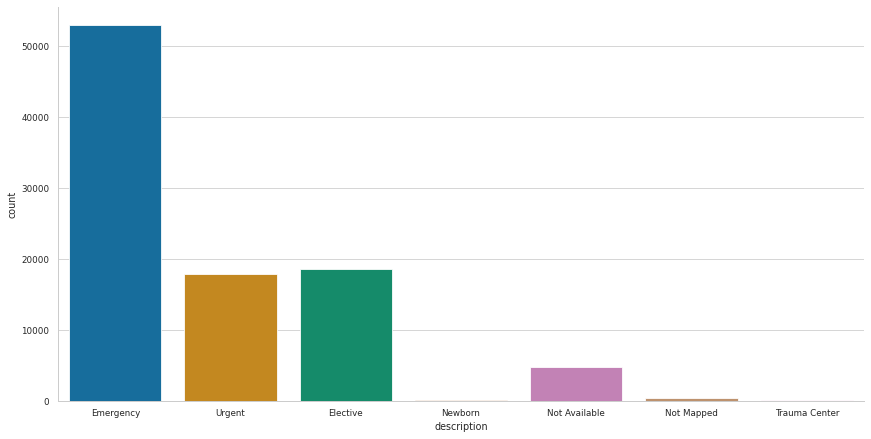

In [27]:
sns.catplot(x = "description", data = diabetic_df, kind = "count", height = 6, aspect = 2);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


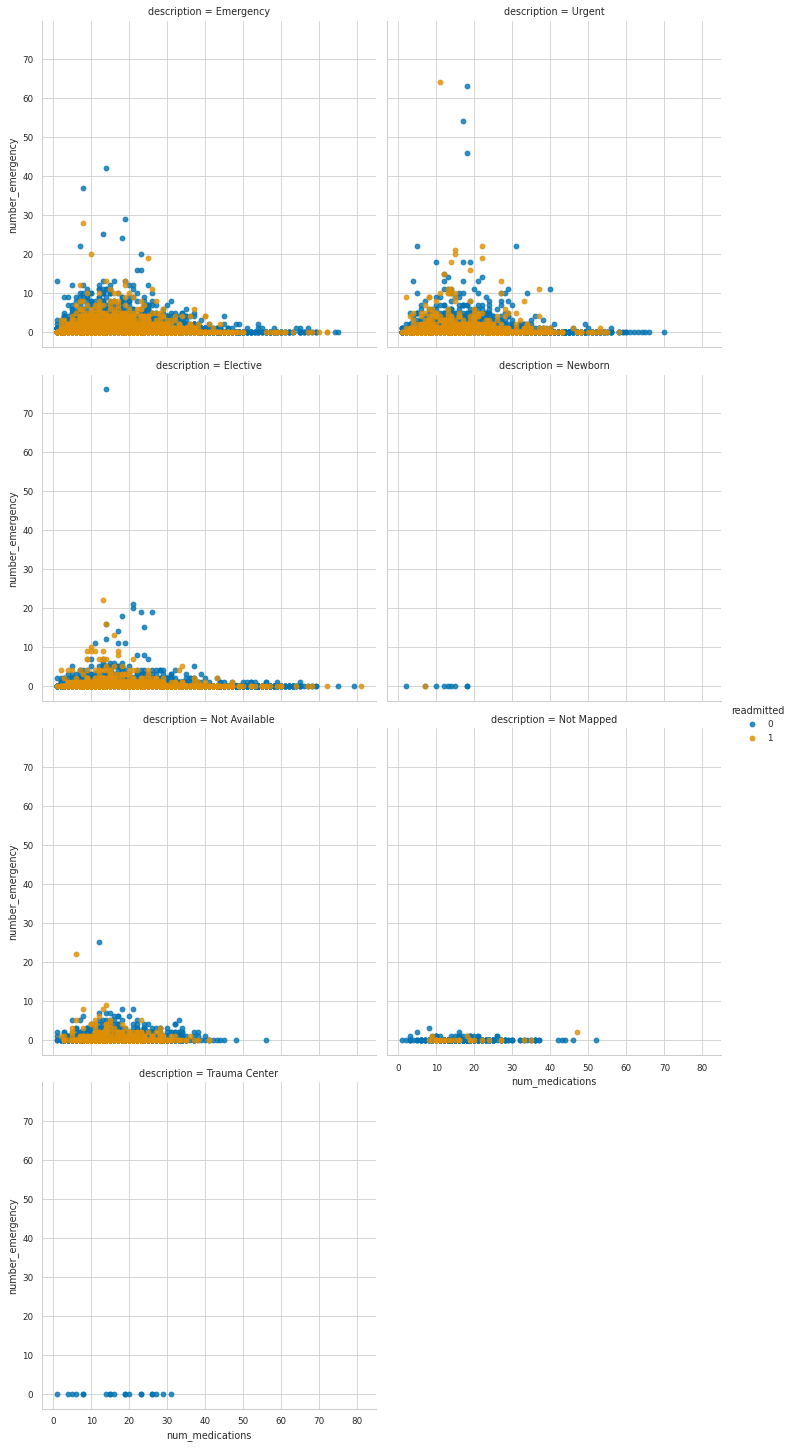

In [28]:
#Relacion num_medicamentos , number_emergency, diag_1, readmitted
sns.lmplot("num_medications", "number_emergency", data=diabetic_df, hue="readmitted", fit_reg=False, col='description', col_wrap=2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


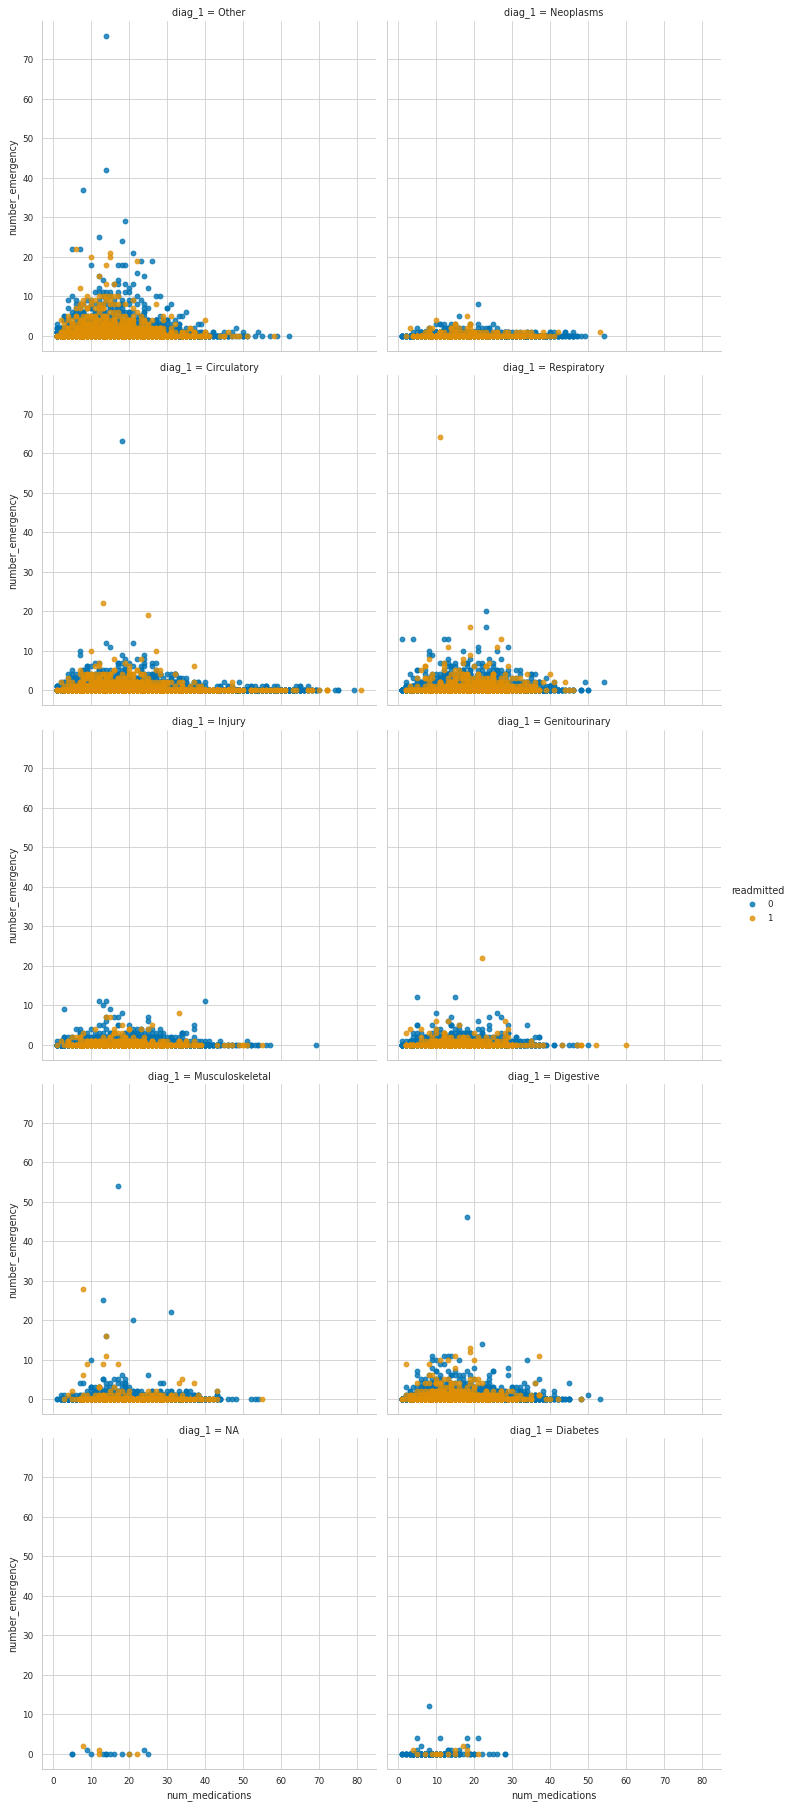

In [29]:
#Relacion num_medicamentos , number_emergency, diag_1, readmitted
sns.lmplot("num_medications", "number_emergency", data=diabetic_df, hue="readmitted", fit_reg=False, col='diag_1', col_wrap=2)

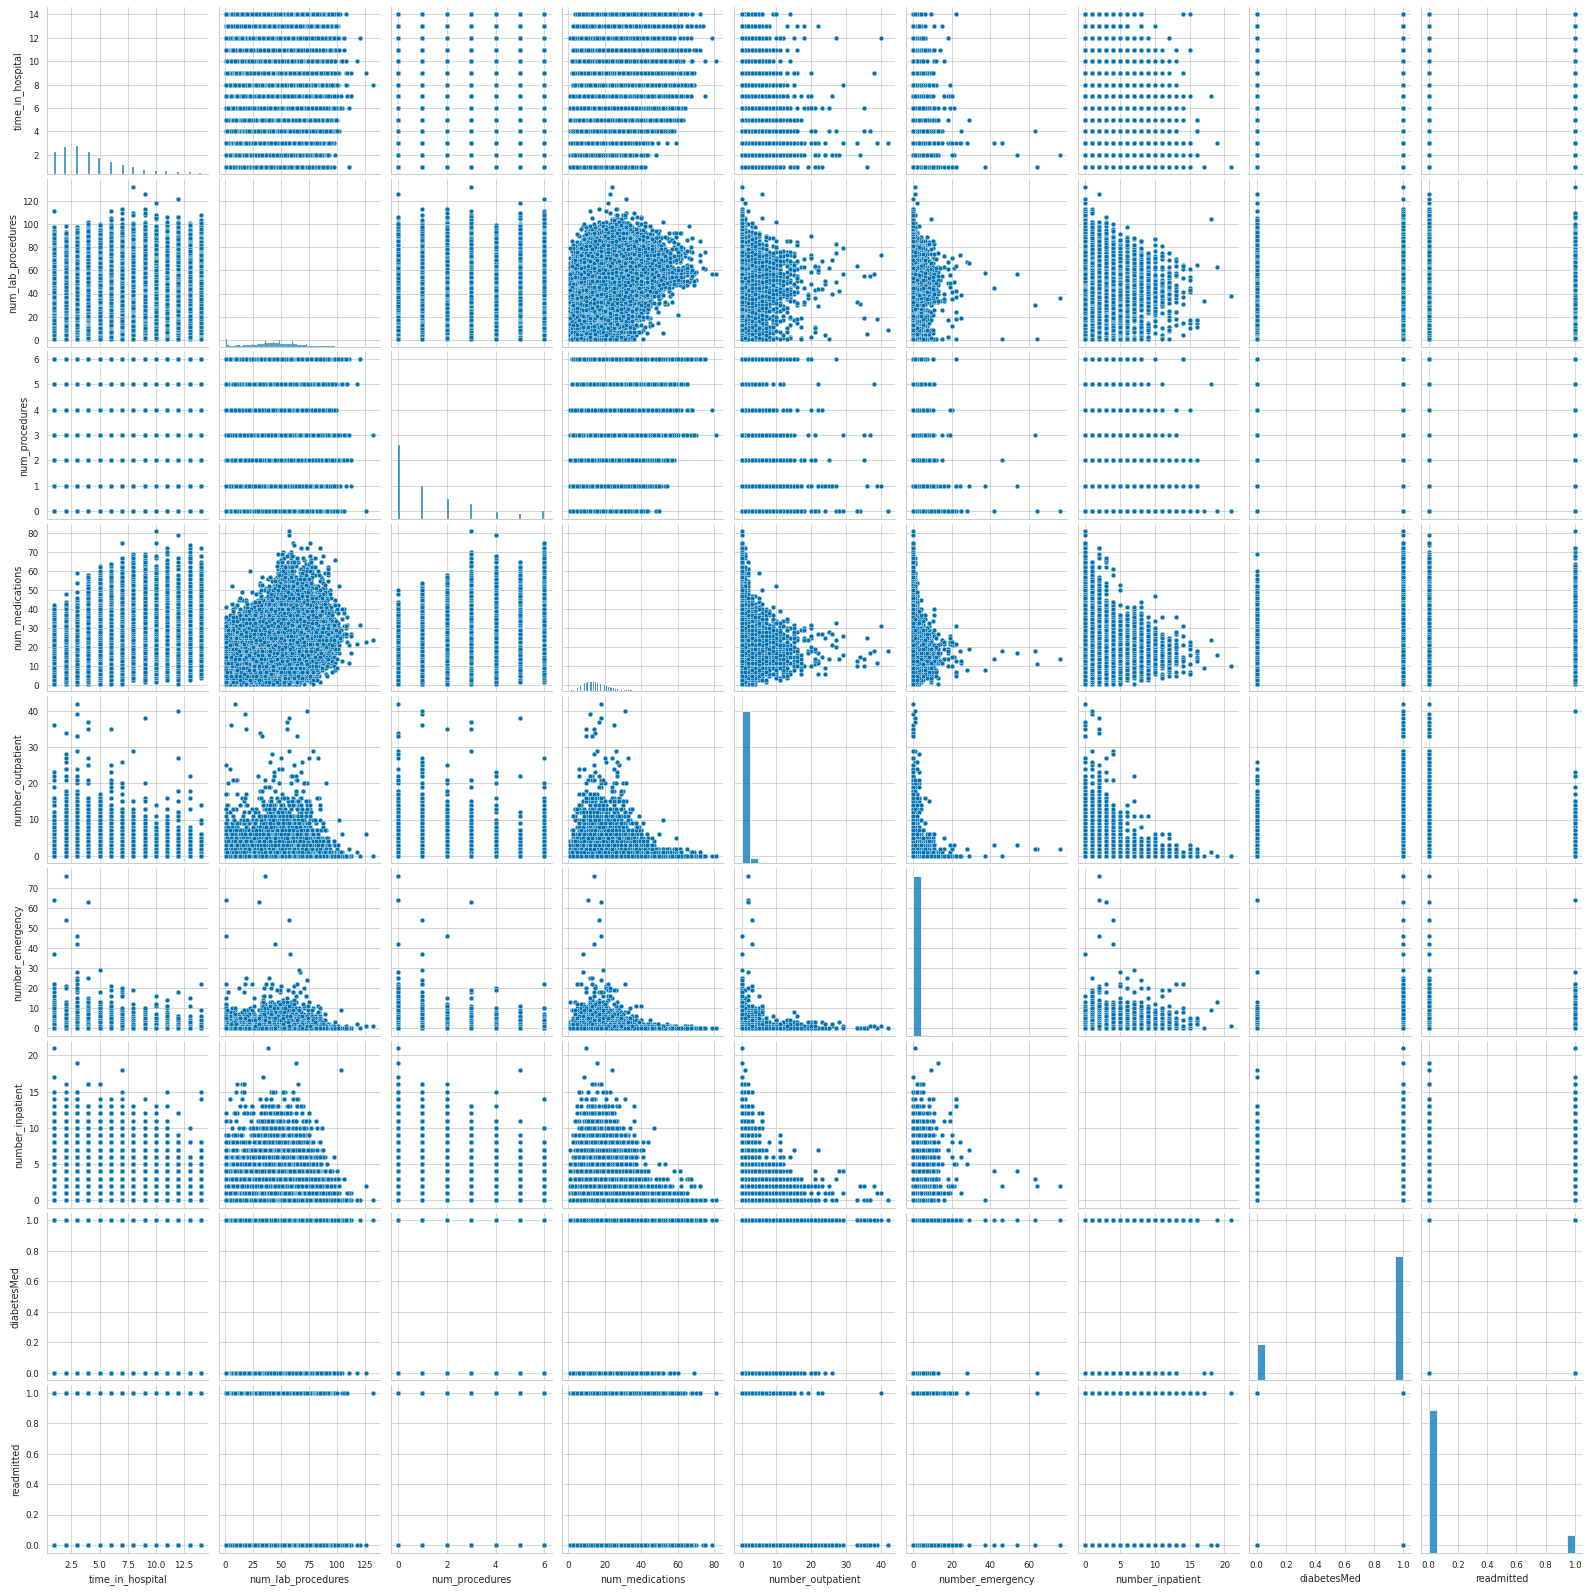

In [30]:
sns.pairplot(diabetic_df.iloc[:,[5,6,7,8,9,10,11,12,16,39,40]])

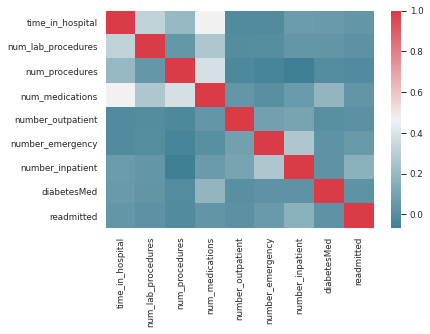

In [31]:
corr = diabetic_df.iloc[:,[5,6,7,8,9,10,11,12,16,39,40]].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [32]:
df_1=diabetic_df.groupby(['race', 'description']).agg({'description':['count'],'readmitted': ['sum']}).reset_index()
df_1.columns = ['race', 'description','cantidad','readmitted']
df_1['porcentaje']=df_1['readmitted']/df_1['cantidad'] * 100

In [33]:
df_1.sort_values('porcentaje',ascending=False)

,race,description,cantidad,readmitted,porcentaje
14,Caucasian,Newborn,5,1,20.000000
22,Hispanic,Not Available,132,19,14.393939
7,Asian,Elective,119,15,12.605042
6,AfricanAmerican,Urgent,2822,346,12.260808
13,Caucasian,Emergency,38467,4503,11.706138
1,AfricanAmerican,Emergency,12457,1415,11.359075
18,Caucasian,Urgent,14074,1585,11.261901
25,Other,Elective,274,30,10.948905
20,Hispanic,Emergency,1022,110,10.763209
12,Caucasian,Elective,14997,1585,10.568780


In [34]:
df_2=diabetic_df.groupby(['race', 'gender']).agg({'description':['count'],'readmitted': ['sum']}).reset_index()
df_2.columns = ['race', 'gender','cantidad','readmitted']
df_2['porcentaje']=df_2['readmitted']/df_2['cantidad'] * 100

In [35]:
df_2.sort_values('porcentaje',ascending=False)

,race,gender,cantidad,readmitted,porcentaje
3,Asian,Male,292,38,13.013699
7,Hispanic,Male,854,103,12.060890
1,AfricanAmerican,Male,7191,827,11.500487
4,Caucasian,Female,37582,4321,11.497525
0,AfricanAmerican,Female,11366,1262,11.103291
5,Caucasian,Male,34348,3806,11.080703
8,Other,Female,697,70,10.043042
9,Other,Male,701,62,8.844508
6,Hispanic,Female,944,79,8.368644
2,Asian,Female,292,22,7.534247


In [36]:
df_3=diabetic_df.groupby(['diag_1', 'max_glu_serum']).agg({'description':['count'],'readmitted': ['sum']}).reset_index()
df_3.columns = ['diag_1', 'max_glu_serum','cantidad','readmitted']
df_3['porcentaje']=df_3['readmitted']/df_3['cantidad'] * 100
df_3.sort_values('porcentaje',ascending=False)

,diag_1,max_glu_serum,cantidad,readmitted,porcentaje
23,NA,None,17,5,29.411765
8,Digestive,>300,86,18,20.930233
26,Neoplasms,>300,22,4,18.181818
12,Genitourinary,>300,18,3,16.666667
1,Circulatory,>300,175,27,15.428571
30,Other,>300,316,45,14.240506
0,Circulatory,>200,282,40,14.184397
16,Injury,>300,31,4,12.903226
14,Genitourinary,Norm,86,11,12.790698
36,Respiratory,Norm,319,40,12.539185


In [37]:
df_4=diabetic_df.groupby(['race', 'diabetesMed']).agg({'description':['count'],'readmitted': ['sum'],'time_in_hospital': ['mean']}).reset_index()
df_4.columns = ['race', 'diabetesMed','cantidad','readmitted','time_in_hospital']
df_4['porcentaje']=df_4['readmitted']/df_4['cantidad'] * 100
df_4.sort_values('porcentaje',ascending=False)

,race,diabetesMed,cantidad,readmitted,time_in_hospital,porcentaje
5,Caucasian,1,55463,6595,4.490507,11.890810
1,AfricanAmerican,1,14326,1638,4.545302,11.433757
0,AfricanAmerican,0,4231,451,4.360435,10.659419
3,Asian,1,437,45,4.109840,10.297483
2,Asian,0,147,15,3.578231,10.204082
7,Hispanic,1,1390,141,4.069784,10.143885
6,Hispanic,0,408,41,3.703431,10.049020
9,Other,1,1149,112,4.369887,9.747607
4,Caucasian,0,16467,1532,3.985668,9.303455
8,Other,0,249,20,3.614458,8.032129


In [38]:
def chi_cuadrado(df,target_variable,probabilidad = 0.95):
  columna=[]
  probabilidad_valores=[]
  stat_valores=[]
  intrepretacion_stat=[]
  alfa_valores=[]
  p_value_valores=[]
  intrepretacion_p_value=[]
  dof_valores=[]

  columnas=list(df.columns)
  columnas.remove(target_variable) 


  for col in columnas:
    columna.append(col)
    probabilidad_valores.append(probabilidad)

    data_crosstab = pd.crosstab(df[col], 
                                df[target_variable],  
                               margins = False)
    
    stat, p, dof, expected = chi2_contingency(data_crosstab)

    stat_valores.append(stat)
    p_value_valores.append(p)
    dof_valores.append(dof)

    critical = chi2.ppf(probabilidad, dof)
    if abs(stat) >= critical:
      intrepretacion='Dependent (reject H0)'
    else:
      intrepretacion='Independent (fail to reject H0)'
    
    intrepretacion_stat.append(intrepretacion)

    alpha = 1.0 - probabilidad
    alfa_valores.append(alpha)
    if p <= alpha:
      texto='Dependent (reject H0)'
    else:
      texto='Independent (fail to reject H0)'
    
    intrepretacion_p_value.append(texto)

  chi_base_df = pd.DataFrame({"columna":columna,"probabilidad":probabilidad_valores,"stat":stat_valores,"intrepretacion stat":intrepretacion_stat,
                              "alpha":alfa_valores,"p value":p_value_valores,"intrepretacion p value":intrepretacion_p_value,"dof":dof_valores
                              })
    
  return chi_base_df


In [39]:
columnas_chi_list=['readmitted', 'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin','glyburide-metformin',
        'glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone']

chi_cuadrado(diabetic_df[columnas_chi_list],'readmitted',probabilidad = 0.95)


,columna,probabilidad,stat,intrepretacion stat,alpha,p value,intrepretacion p value,dof
0,A1Cresult,0.95,32.060133,Dependent (reject H0),0.05,5.082951e-07,Dependent (reject H0),3
1,metformin,0.95,54.048355,Dependent (reject H0),0.05,1.095730e-11,Dependent (reject H0),3
2,repaglinide,0.95,11.246686,Dependent (reject H0),0.05,1.046407e-02,Dependent (reject H0),3
3,nateglinide,0.95,1.317883,Independent (fail to reject H0),0.05,7.248910e-01,Independent (fail to reject H0),3
4,chlorpropamide,0.95,2.138466,Independent (fail to reject H0),0.05,5.441700e-01,Independent (fail to reject H0),3
5,glimepiride,0.95,5.640227,Independent (fail to reject H0),0.05,1.304880e-01,Independent (fail to reject H0),3
6,acetohexamide,0.95,1.507033,Independent (fail to reject H0),0.05,2.195923e-01,Independent (fail to reject H0),1
7,glipizide,0.95,12.439816,Dependent (reject H0),0.05,6.018825e-03,Dependent (reject H0),3
8,glyburide,0.95,2.733516,Independent (fail to reject H0),0.05,4.345615e-01,Independent (fail to reject H0),3
9,tolbutamide,0.95,0.430302,Independent (fail to reject H0),0.05,5.118409e-01,Independent (fail to reject H0),1


## **Modelo de clasificación**

In [40]:
diabetic_df_dummies = pd.get_dummies(diabetic_df)

In [41]:
diabetic_df_dummies.head()

,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),diag_1_Circulatory,diag_1_Diabetes,diag_1_Digestive,diag_1_Genitourinary,diag_1_Injury,diag_1_Musculoskeletal,diag_1_NA,diag_1_Neoplasms,diag_1_Other,diag_1_Respiratory,...,dignosticos_Other Digestive Diabetes,dignosticos_Other Digestive Genitourinary,dignosticos_Other Digestive Injury,dignosticos_Other Digestive Respiratory,dignosticos_Other Genitourinary,dignosticos_Other Genitourinary Circulatory,dignosticos_Other Genitourinary Diabetes,dignosticos_Other Genitourinary Injury,dignosticos_Other Genitourinary Respiratory,dignosticos_Other Injury,dignosticos_Other Injury Circulatory,dignosticos_Other Injury Respiratory,dignosticos_Other Musculoskeletal,dignosticos_Other Musculoskeletal Circulatory,dignosticos_Other Musculoskeletal Diabetes,dignosticos_Other Musculoskeletal Digestive,dignosticos_Other Musculoskeletal Genitourinary,dignosticos_Other Musculoskeletal Injury,dignosticos_Other Musculoskeletal Neoplasms,dignosticos_Other Musculoskeletal Respiratory,dignosticos_Other Neoplasms,dignosticos_Other Neoplasms Circulatory,dignosticos_Other Neoplasms Diabetes,dignosticos_Other Neoplasms Digestive,dignosticos_Other Neoplasms Genitourinary,dignosticos_Other Neoplasms Injury,dignosticos_Other Neoplasms Respiratory,dignosticos_Other Respiratory,dignosticos_Other Respiratory Circulatory,dignosticos_Other Respiratory Injury,dignosticos_Respiratory,dignosticos_Respiratory Circulatory,dignosticos_Respiratory Diabetes Injury,dignosticos_Respiratory Digestive Injury,dignosticos_Respiratory Genitourinary Injury,dignosticos_Respiratory Injury,dignosticos_Respiratory Injury Circulatory,dignosticos_Respiratory Injury Other,dignosticos_Respiratory Musculoskeletal Injury,dignosticos_Respiratory Neoplasms Injury
1,1,7,3,59,0,18,0,0,0,9,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,7,2,11,5,13,2,0,1,6,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,7,2,44,1,16,0,0,0,7,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,7,1,51,0,8,0,0,0,5,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,2,3,31,6,16,0,0,0,9,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
def scaler_X(df):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(df)
  return X_scaled

In [43]:
y_df=diabetic_df_dummies['readmitted']
X_df = diabetic_df_dummies.drop(['readmitted'],axis=1)

In [44]:
X_scaled = scaler_X(X_df)

In [45]:
  param_grid = {'n_estimators': [10,50],
              'max_features': [5,10,20,50],
              'max_depth'   : [ 3,  4,5],
              'criterion'   : ['entropy']
             }

In [46]:
  w = 70
  model = GridSearchCV(
        estimator  = RandomForestClassifier(class_weight={0: w, 1: 1},random_state = 9),
        param_grid = param_grid,
        scoring    = 'roc_auc',
        n_jobs     = multiprocessing.cpu_count() - 1,
        refit      = True,
        verbose    = 0,
        return_train_score = True)

In [47]:
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_scaled, y_df, test_size=0.3, random_state=8)

In [48]:
model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 70, 1: 1},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=9,
                       

In [49]:
auc_train = metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
auc_test = metrics.roc_auc_score(Y_validation, model.predict_proba(X_validation)[:,1])
print("AUC train:  "+ str(auc_train))
print("AUC test:  "+ str(auc_test))
print(model.best_params_)

AUC train:  0.671762803590719
AUC test:  0.6526155917043988
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 50, 'n_estimators': 50}
